In [15]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils as imu
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
def show(im, cmap=None):
    plt.imshow(im, cmap=cmap, interpolation="bilinear")

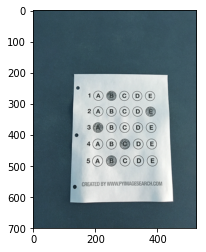

In [16]:
orig_im = cv2.imread('utils/exam.png')
ANSWERS = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}
show(orig_im)

#### preprocess

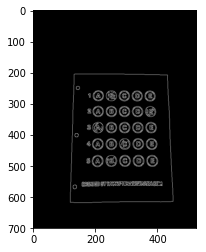

In [17]:
gray_im = cv2.cvtColor(orig_im, cv2.COLOR_BGR2GRAY)
im = cv2.GaussianBlur(gray_im, (5, 5), 0)
im = cv2.Canny(im, 75, 200)
show(im, cmap='gray')

#### find contours

In [18]:
cnts = cv2.findContours(im.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imu.grab_contours(cnts)

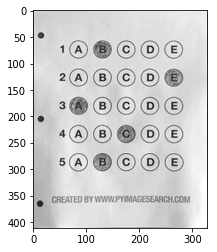

In [19]:
# sort the contours according to their size in descending order
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
# loop over the sorted contours
for c in cnts:
    peri = cv2.arcLength(c, True) # approximate the contour
    docCnt = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points,
    # then we can assume we have found the paper
    if len(docCnt) == 4: break
im = imu.perspective.four_point_transform(gray_im, docCnt.reshape(4,2))
show(im, cmap='gray')

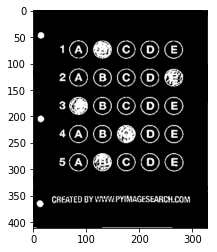

In [20]:
im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
show(im, cmap='gray')

In [21]:
# find contours in the thresholded image, then initialize
# the list of contours that correspond to questions
cnts = cv2.findContours(im.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imu.grab_contours(cnts)
questionCnts = []
for c in cnts:
    # compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = w / float(h)
    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ratio >= 0.9 and ratio <= 1.1:
        questionCnts.append(c)
len(questionCnts), questionCnts[1].shape

(25, (44, 1, 2))

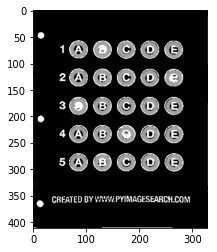

In [22]:
r = im.copy()
for c in questionCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    x, y = int(x+w/2), int(y+h/2)
    cv2.circle(r, (x,y), 12, (160,0,120), 5)
show(r, cmap='gray')

(817, 1)
(686, 4)
(794, 0)
(805, 2)
(722, 1)


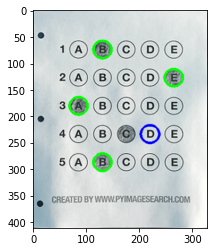

In [24]:
r = imu.perspective.four_point_transform(orig_im, docCnt.reshape(4,2))
# sort the question contours top-to-bottom, then initialize
# the total number of correct answers
questionCnts = imu.contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from left 
    # to right, then initialize the index of the bubbled answer
    cnts = imu.contours.sort_contours(questionCnts[ i:i+5 ])[0]
    bubbled = None
    # loop over the sorted contours
    for j,c in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        mask = np.zeros(im.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the bubble area
        mask = cv2.bitwise_and(im, im, mask=mask)
        total = cv2.countNonZero(mask)
        # if the current total has a larger number of total non-zero 
        # pixels, then we are examining the currently bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)
    print(bubbled)
    # initialize the contour color and the index of the *correct* answer
    color = (0, 0, 255)
    k = ANSWERS[q]
    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1
    # draw the outline of the correct answer on the test
    cv2.drawContours(r, [cnts[k]], -1, color, 3)
show(r)